In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

In [2]:
# String formatting from NLP notebook

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

animes = pd.read_csv('data/anime_with_synopsis.csv')

# Formatting
animes.dropna(subset=['Synopsis'], inplace=True)
animes['Synopsis'] = animes['Synopsis'].str.lower()

animes['Synopsis'] = animes['Synopsis'].apply(word_tokenize)

custom_stopwords = ['s', 'source', 'ann', 'episode', 'series', 'anime', 'synopsis']
custom_stopwords.extend(stopwords.words('english'))
animes['Synopsis'] = animes['Synopsis'].apply(lambda x: [word for word in x if word not in custom_stopwords])

animes['Synopsis'] = animes['Synopsis'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
animes['Synopsis'] = animes['Synopsis'].apply(lambda x : [word for word in x if len(word) > 0])

lemmatizer = WordNetLemmatizer()
animes['Synopsis'] = animes['Synopsis'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
animes['Synopsis'] = animes['Synopsis'].apply(lambda x: [word for word in x if word != "s"])

animes['Synopsis'] = animes['Synopsis'].apply(lambda x: ' '.join(x))

animes = animes[animes['Genres'] != 'Unknown']
animes['Genres'] = animes['Genres'].str.split(', ')

animes

,MAL_ID,Name,Score,Genres,Synopsis
0,1,Cowboy Bebop,8.78,"[Action, Adventure, Comedy, Drama, Sci-Fi, Space]",year 2071 humanity colonized several planet mo...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[Action, Drama, Mystery, Sci-Fi, Space]",day another bounty—such life often unlucky cre...
2,6,Trigun,8.24,"[Action, Sci-Fi, Adventure, Comedy, Drama, Sho...",vash stampede man 60000000000 bounty head reas...
3,7,Witch Hunter Robin,7.27,"[Action, Mystery, Police, Supernatural, Drama,...",ches individual special power like esp telekin...
4,8,Bouken Ou Beet,6.98,"[Adventure, Fantasy, Shounen, Supernatural]",dark century people suffering rule devil vande...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"[Adventure, Mystery, Supernatural]",information added title help improve database ...
16210,48483,Mieruko-chan,Unknown,"[Comedy, Horror, Supernatural]",ko typical high school student whose life turn...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"[Mystery, Dementia, Horror, Psychological, Sup...",sequel higurashi naku koro ni gou
16212,48491,Yama no Susume: Next Summit,Unknown,"[Adventure, Slice of Life, Comedy]",new yama susume


In [3]:
# get all genre tags in a list
all_genres = sum(animes['Genres'],[])
len(set(all_genres))

41

In [4]:
# Frequency of each genre
from nltk.probability import FreqDist

all_genres = FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
all_genres_df = all_genres_df.sort_values('Count', ascending=False)

all_genres_df

,Genre,Count
2,Comedy,5971
0,Action,3846
11,Fantasy,3202
1,Adventure,2942
38,Kids,2660
3,Drama,2589
4,Sci-Fi,2550
35,Music,2240
7,Shounen,2003
15,Slice of Life,1910


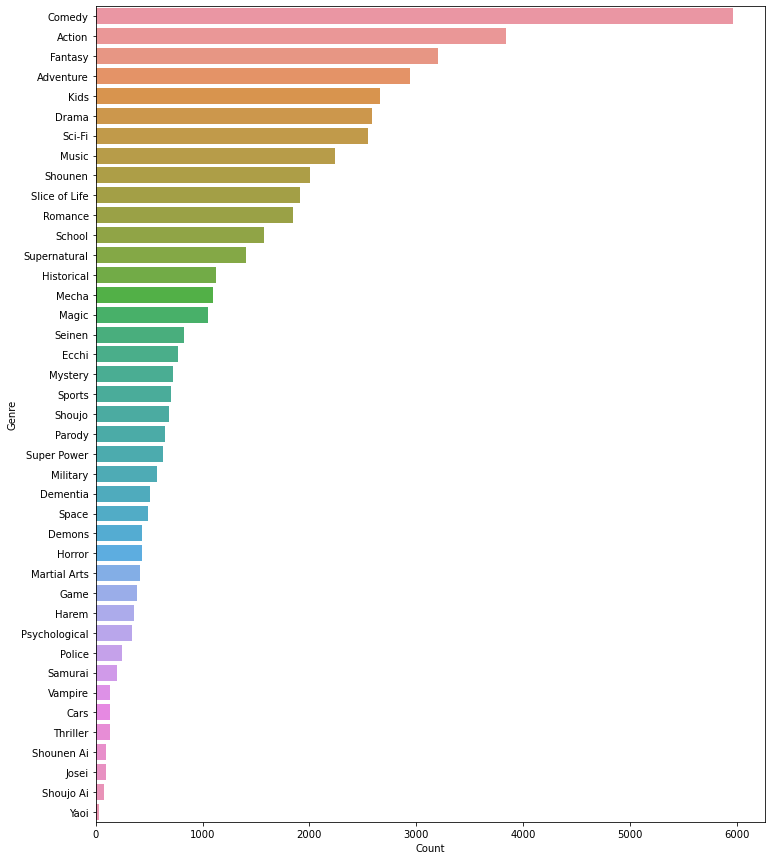

In [5]:
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=all_genres_df, x= "Count", y = "Genre") 
plt.show()

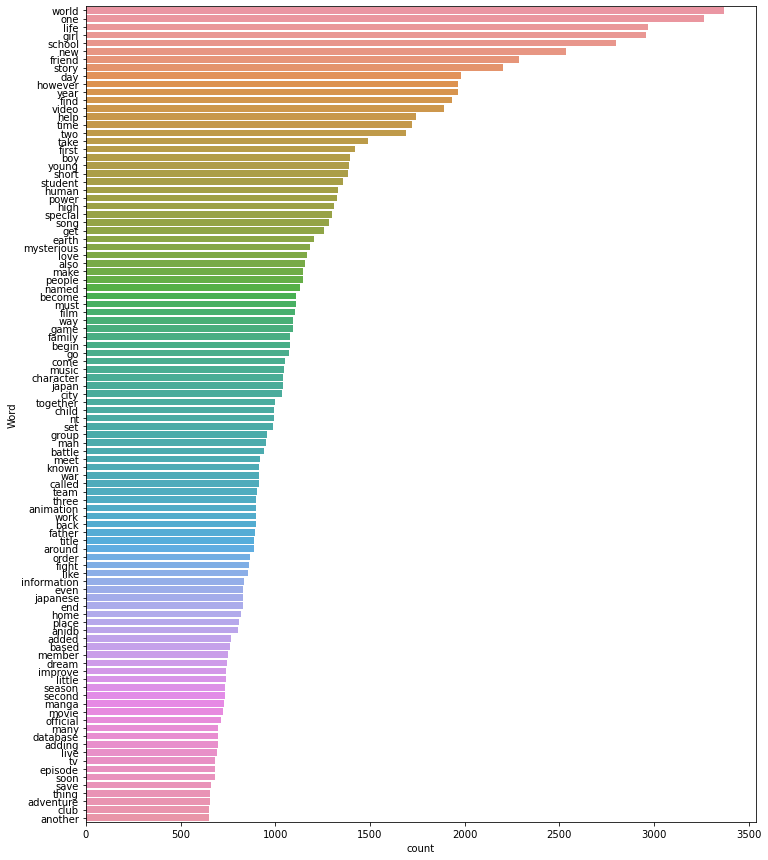

In [6]:
# Most commmon words

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(animes['Synopsis'], 100)

In [7]:
# Solve this multi-label classification problem by treating it as a series of binary classifications aka binary relevance

# One hot incode each possible classification (the genres)
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(animes['Genres'])

# transform target variable
y = multilabel_binarizer.transform(animes['Genres'])

y.shape # each row is an anime, each column is a genre

(16143, 41)

In [8]:
# split dataset into training and validation set
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(animes['Synopsis'], y, test_size=0.05) # 95-5 split

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [10]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

lr = LogisticRegression(max_iter=500)
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

y_pred # one hot encoded array of genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
multilabel_binarizer.inverse_transform(y_pred)[0] # convert array to genre labels

()

In [12]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.3747192813602824

In [13]:
# Before, if probability > 0.5, encode 1, else 0. New threshold of probability > 0.3:

# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

t = 0.2 # threshold value
y_pred_new = (y_pred_prob > t).astype(int)

# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5440786984487325

In [14]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred_prob = clf.predict_proba(q_vec)
    t = 0.2
    q_pred_new = (q_pred_prob >= t).astype(int)
    return multilabel_binarizer.inverse_transform(q_pred_new)

anime = animes[animes['Name']=='Shigatsu wa Kimi no Uso'].squeeze(axis=0)
print("Anime: ", anime['Name'], "\nPredicted genre: ", infer_tags(anime['Synopsis']), "\nActual genre: ", anime['Genres'], "\n")

Anime:  Shigatsu wa Kimi no Uso 
Predicted genre:  [('Comedy', 'Drama', 'Music', 'Romance')] 
Actual genre:  ['Drama', 'Music', 'Romance', 'School', 'Shounen'] 

